In [1]:
import timeit
import matplotlib.pyplot as plt
import pickle
from time import time
import numpy as np

In [2]:
from mnist import MNIST
print("Loading dataset....")
mndata = MNIST('../mnist_dataset')
X_train, y_train = mndata.load_training()
X_train = (mndata.process_images_to_numpy(X_train)/255).astype(np.float32)
X_test, y_test = mndata.load_testing()
X_test = (mndata.process_images_to_numpy(X_test)/255).astype(np.float32)
print("Done.")

Loading dataset....
Done.


In [3]:
del y_train
del y_test
del mndata
# for tanh
X_train=X_train*2 - 1
X_test=X_test*2 - 1
X_train=np.concatenate([X_train,X_test]).reshape(-1,28,28,1)

In [4]:
from nnet_gpu.network import Sequential
from nnet_gpu.layers import Conv2D,Flatten,Dense,Dropout,Conv2Dtranspose,Reshape,BatchNormalization
from nnet_gpu import functions
from nnet_gpu import optimizers
import numpy as np
import cupy as cp

In [5]:
def generator():
    model=Sequential()
    model.add(Dense(128*7*7,activation=functions.leakyRelu,input_shape=100))
    model.add(Reshape((7,7,128)))
#     model.add(Upsampling())
#     model.add(Conv2D(64,kernel_size=3,activation=functions.leakyRelu))
    model.add(Conv2Dtranspose(64,kernel_size=3,stride=[2,2],activation=functions.leakyRelu))
    model.add(BatchNormalization())
#     model.add(Upsampling())
#     model.add(Conv2D(32,kernel_size=3,activation=functions.leakyRelu))
    model.add(Conv2Dtranspose(32,kernel_size=3,stride=[2,2],activation=functions.leakyRelu))
    model.add(BatchNormalization())
    model.add(Conv2Dtranspose(1,kernel_size=3,activation=functions.tanh))
    return model
g=generator()
g.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
- InputLayer(InputLayer)  (None, 100)                echo             0
__________________________________________________________________________________________
0 Dense(Dense)            (None, 6272)               leakyRelu        633472
__________________________________________________________________________________________
1 Reshape(Reshape)        (None, 7, 7, 128)          echo             0
__________________________________________________________________________________________
2 Conv2Dtranspose(Conv2Dt (None, 14, 14, 64)         leakyRelu        73792
__________________________________________________________________________________________
3 BatchNormalization(Batc (None, 14, 14, 64)         echo             256
__________________________________________________________________________________________
4 Con

In [6]:
def discriminator():
    model=Sequential()
    model.add(Conv2D(64,kernel_size=3,stride=[2,2],activation=functions.leakyRelu,input_shape=(28,28,1)))
#     model.add(MaxPool())
    model.add(Dropout(0.25))
    model.add(Conv2D(128,kernel_size=3,stride=[2,2],activation=functions.leakyRelu))
#     model.add(MaxPool())
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(100,activation=functions.sigmoid))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation=functions.sigmoid))
    return model
d=discriminator()
d.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
- InputLayer(InputLayer)  (None, 28, 28, 1)          echo             0
__________________________________________________________________________________________
0 Conv2D(Conv2D)          (None, 14, 14, 64)         leakyRelu        640
__________________________________________________________________________________________
1 Dropout(Dropout)        (None, 14, 14, 64)         echo             0
__________________________________________________________________________________________
2 Conv2D(Conv2D)          (None, 7, 7, 128)          leakyRelu        73856
__________________________________________________________________________________________
3 BatchNormalization(Batc (None, 7, 7, 128)          echo             512
__________________________________________________________________________________________
4 Dropou

In [7]:
g.compile(optimizer=optimizers.adam,loss=functions.mean_squared_error, learning_rate=0.002)
d.compile(optimizer=optimizers.adam,loss=functions.cross_entropy, learning_rate=0.002)

In [8]:
noise=cp.random.randn(64,100,dtype=cp.float32)
gen=g.predict(noise)

In [49]:
def gen_sample(n=4):
    noise=cp.random.randn(n,100,dtype=cp.float32)
    gen=g.predict(noise)
    plt.figure(figsize=(4*n,4))
    plt.imshow(((gen.transpose(1,0,2,3).reshape(28,n*28)+1)/2).get(), cmap='Greys')
    plt.show()
    print(d.predict(gen).T)

In [10]:
X_train=cp.asarray(X_train)

In [55]:
def run(batch_size=64):
    dsz=X_train.shape[0]
    # Label real ones as 90% real
    y_fake=cp.zeros((batch_size,1),dtype=cp.float32)
    y_real=cp.ones((batch_size,1),dtype=cp.float32)
    y_gen=cp.ones((batch_size,1),dtype=cp.float32)
    for step in range(dsz//batch_size):
        stt=time()
        noise=cp.random.randn(batch_size,100,dtype=cp.float32)
        # Generate fake images from noise
        generated_images=g.predict(noise)
        # Get random real images
        real_images=X_train[cp.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
#         X = cp.concatenate([real_images,generated_images])
        # Train discriminator
        y_real=cp.random.uniform(0.9,1,(batch_size,1),dtype=cp.float32)
        y_fake=cp.random.uniform(0,0.1,(batch_size,1),dtype=cp.float32)
        dout1=d.train_on_batch(real_images,y_real)
        dout2=d.train_on_batch(generated_images,y_fake)
        dloss=functions.cross_entropy(outputs=dout2,labels=y_fake).sum()
        # Treat noised input of generator as real data
        noise=cp.random.randn(batch_size,100,dtype=cp.float32)
        # Train generator
        gout=g.forward(noise)
        # do not train discriminator and find delta for generator
        dout,err=d.not_train_on_batch(gout,y_gen)
        g.backprop(err)
        g.optimizer(g.sequence,g.learning_rate,g.beta)
        if not step%400:
            gen_sample()
        print("\rProgress: {:.2f} %     Dloss: {}    err: {}     Sample time: {:.3f}s    _".format(step*batch_size*100/dsz,dloss,abs(err).sum(),time()-stt),end='')

In [ ]:
epochs=5
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run(16)
    print("\nEpoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    gen_sample()

## # Using generator with just batch size 1 for first time is causing images to be generated extreme

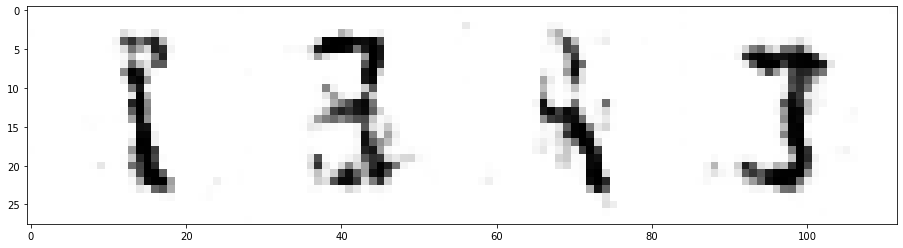

[0.75706345]


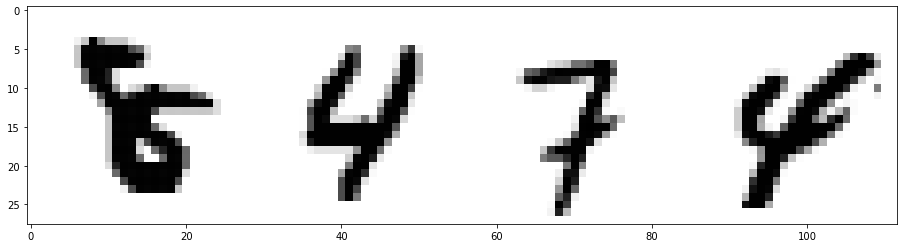

[[0.62077975 0.87345904 0.81087774 0.34875375]]


In [107]:
noise=cp.random.randn(128,100,dtype=cp.float32)
gen=g.predict(noise)
gen_sample(4)
img=X_train[cp.random.randint(low=0,high=X_train.shape[0],size=4)]
plt.figure(figsize=(4*n,4))
plt.imshow(((img.transpose(1,0,2,3).reshape(28,4*28)+1)/2).get(), cmap='Greys')
plt.show()
print(d.predict(img).T)

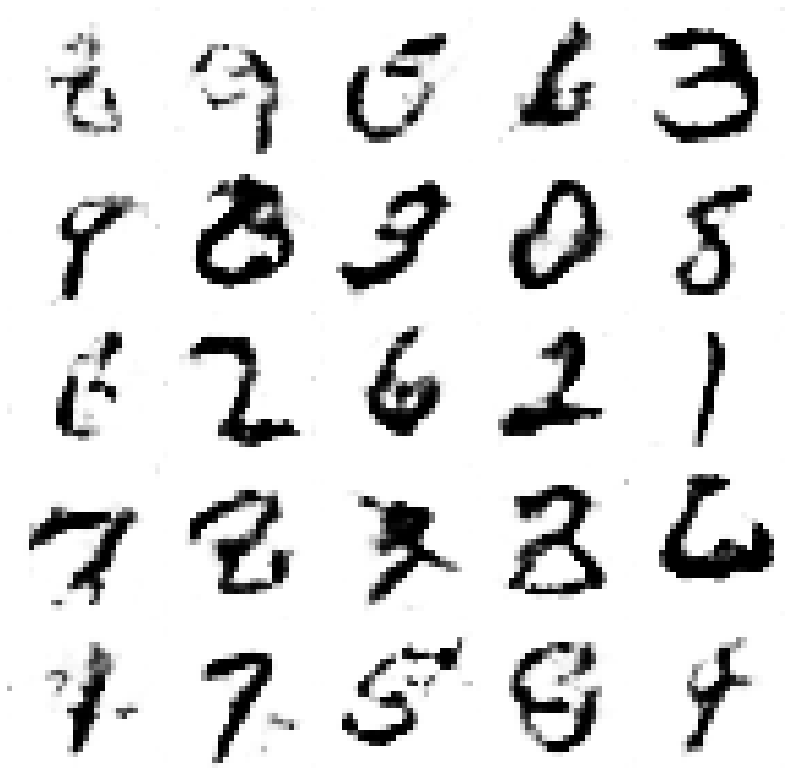

In [112]:
fig, ax = plt.subplots(nrows=5,ncols=5,figsize=[14,14],gridspec_kw = {'wspace':0, 'hspace':0})
fig.patch.set_facecolor('white')
noise=cp.random.randn(25,100,dtype=cp.float32)
gen=g.predict(noise)
for i,axi in enumerate(ax.flat):
    axi.axis("off")
    axi.imshow(((gen[i].squeeze()+1)/2).get(), cmap='Greys')

In [117]:
def interpolate(p1, p2, n=10):
    path = np.linspace(p1.get(),p2.get(),n)
    gen = g.predict(cp.asarray(path, dtype=cp.float32))
    plt.figure(figsize=(3*n,3))
    plt.imshow(((gen.transpose(1,0,2,3).reshape(28,n*28)+1)/2).get(), cmap='Greys')
    plt.show()

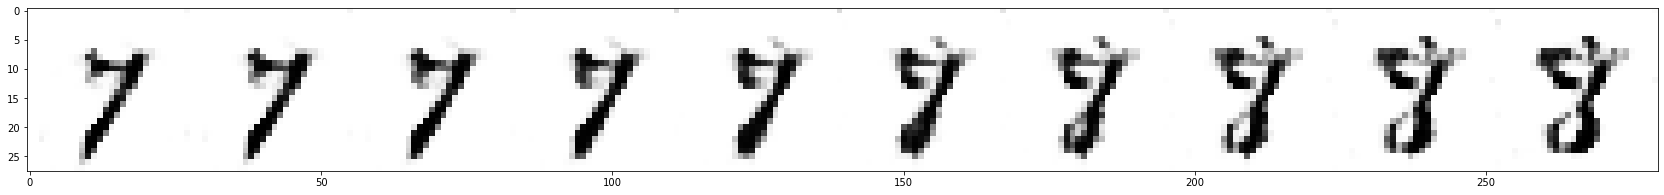

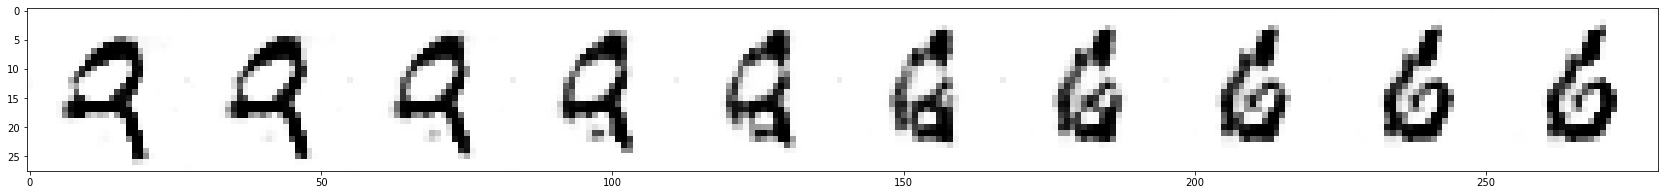

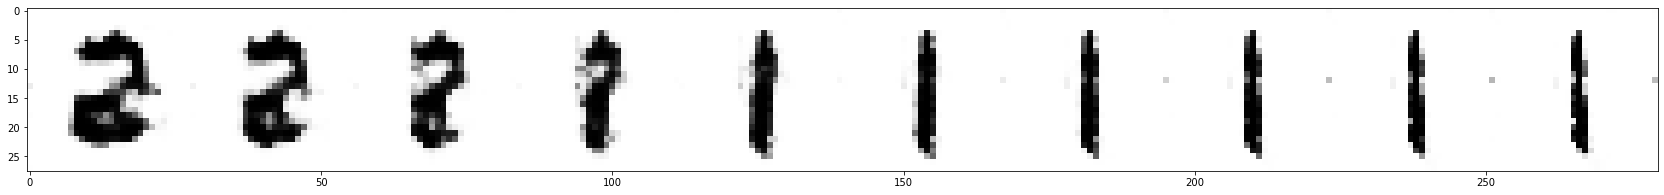

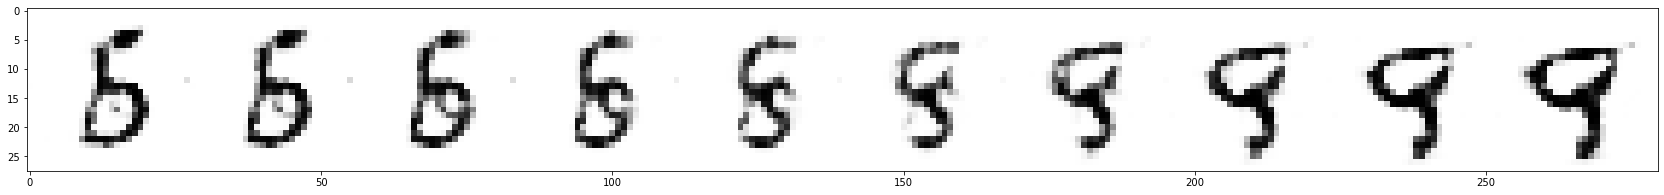

In [137]:
for i in range(4):
    interpolate(cp.random.randn(100,dtype=cp.float32),cp.random.randn(100,dtype=cp.float32))